# DBSCAN. Практическая работа

## Цель практической работы

Научиться строить модели кластеризации с помощью метода DBSCAN.

## Что входит в работу


- Загрузите данные и проведите разведочный анализ.
- Предположите оптимальное количество кластеров.
- Постройте модель кластеризации DBSCAN.
- Определите оптимальное количество и структуру кластеров.
- Интерпретируйте полученные результаты.

## Что оценивается 

1. Выполнены все задания.
2. Сделаны выводы по результатам разведочного анализа данных.
3. Объяснены выбранные гиперпараметры модели кластеризации.
4. Сделаны выводы о количестве и структуре кластеров.
5. Сделаны выводы по результатам кластеризации.

# Задача

Имеется некоторый набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды. 
* AFDP — перепад давления на воздушном фильтре. 
* GTEP — давление на выходе из газовой турбины. 
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины. 
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа. 
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [2]:
df = pd.read_csv('data/15.3 gt_2015.csv')
print(df.shape)
df.head()

(7384, 11)


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [3]:
# Изменение названия колонок для удобства восприятия.
df.columns = ['temp', 'pressure', 'humidity', 'delta_air_filter', 'pres_exit_turb',
              'temp_in_turb', 'temp_exit_turb', 'energy_output', 'compressor_pres', 'CO', 'NOX' ]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              7384 non-null   float64
 1   pressure          7384 non-null   float64
 2   humidity          7384 non-null   float64
 3   delta_air_filter  7384 non-null   float64
 4   pres_exit_turb    7384 non-null   float64
 5   temp_in_turb      7384 non-null   float64
 6   temp_exit_turb    7384 non-null   float64
 7   energy_output     7384 non-null   float64
 8   compressor_pres   7384 non-null   float64
 9   CO                7384 non-null   float64
 10  NOX               7384 non-null   float64
dtypes: float64(11)
memory usage: 634.7 KB


In [5]:
df.describe()

,temp,pressure,humidity,delta_air_filter,pres_exit_turb,temp_in_turb,temp_exit_turb,energy_output,compressor_pres,CO,NOX
count,7384.000000,7384.00000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000,7384.000000
mean,17.225259,1014.50911,68.647464,3.598909,26.130149,1078.974689,546.642484,133.993380,12.097025,3.129986,59.890509
std,8.095783,6.89543,13.541116,0.610226,4.473737,19.762449,5.489066,16.179208,1.136601,2.234962,11.132464
min,-6.234800,989.40000,24.085000,2.368800,17.698000,1016.000000,516.040000,100.020000,9.870800,0.212800,25.905000
25%,11.073250,1009.67500,59.447250,3.117300,23.147000,1070.500000,544.747500,126.255000,11.465750,1.808175,52.399000
50%,17.456500,1014.00000,70.952000,3.538500,25.331000,1080.300000,549.720000,131.600000,11.933000,2.533400,56.838500
75%,23.684750,1018.30000,79.653750,4.194825,30.018250,1099.900000,550.030000,147.160000,13.148000,3.702550,65.093250
max,37.103000,1036.60000,96.666000,5.239500,40.716000,1100.400000,550.590000,179.500000,15.159000,41.097000,119.680000


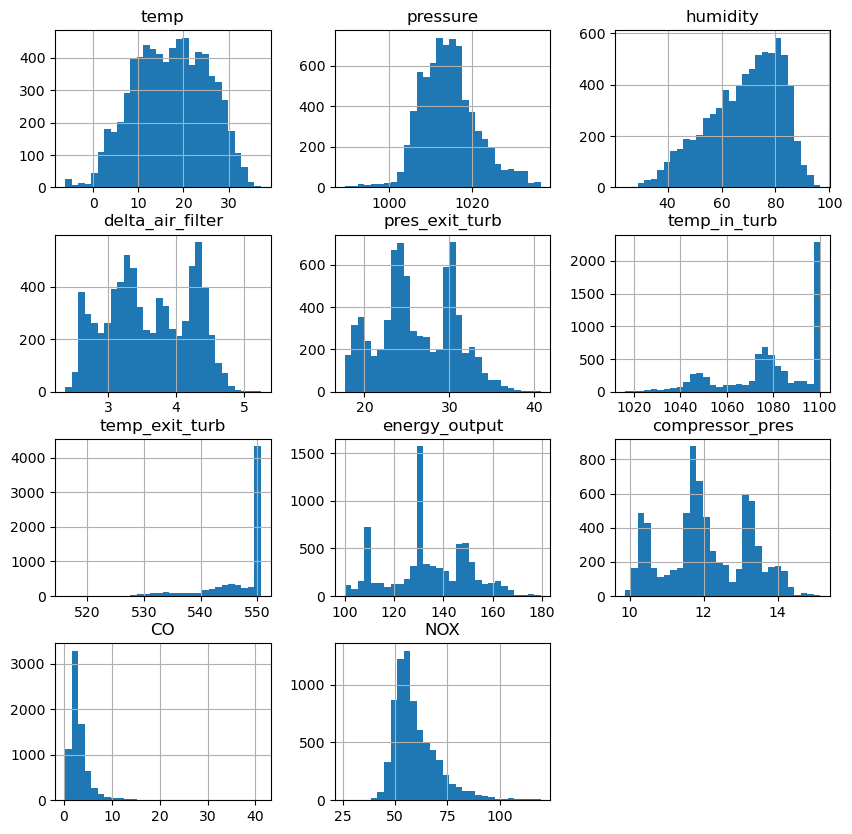

In [6]:
df.hist(bins = 30, figsize= (10, 10) );

In [7]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,temp,pressure,humidity,delta_air_filter,pres_exit_turb,temp_in_turb,temp_exit_turb,energy_output,compressor_pres,CO,NOX
temp,1.000000,-0.493098,-0.466288,0.468976,0.193578,0.330112,0.208277,0.109437,0.200909,-0.390647,-0.593580
pressure,-0.493098,1.000000,0.084381,-0.094144,-0.043730,-0.081605,-0.290147,0.050326,0.029420,0.200945,0.214236
humidity,-0.466288,0.084381,1.000000,-0.245456,-0.297708,-0.260683,0.026251,-0.182732,-0.221706,0.158999,0.065351
delta_air_filter,0.468976,-0.094144,-0.245456,1.000000,0.843958,0.915128,-0.519807,0.884954,0.922991,-0.640789,-0.584452
pres_exit_turb,0.193578,-0.043730,-0.297708,0.843958,1.000000,0.892851,-0.620652,0.932337,0.938142,-0.557177,-0.366655
temp_in_turb,0.330112,-0.081605,-0.260683,0.915128,0.892851,1.000000,-0.396161,0.951813,0.951590,-0.738092,-0.520081
temp_exit_turb,0.208277,-0.290147,0.026251,-0.519807,-0.620652,-0.396161,1.000000,-0.633933,-0.656613,0.025768,0.054455
energy_output,0.109437,0.050326,-0.182732,0.884954,0.932337,0.951813,-0.633933,1.000000,0.991207,-0.616791,-0.403278
compressor_pres,0.200909,0.029420,-0.221706,0.922991,0.938142,0.951590,-0.656613,0.991207,1.000000,-0.612653,-0.443093
CO,-0.390647,0.200945,0.158999,-0.640789,-0.557177,-0.738092,0.025768,-0.616791,-0.612653,1.000000,0.678394


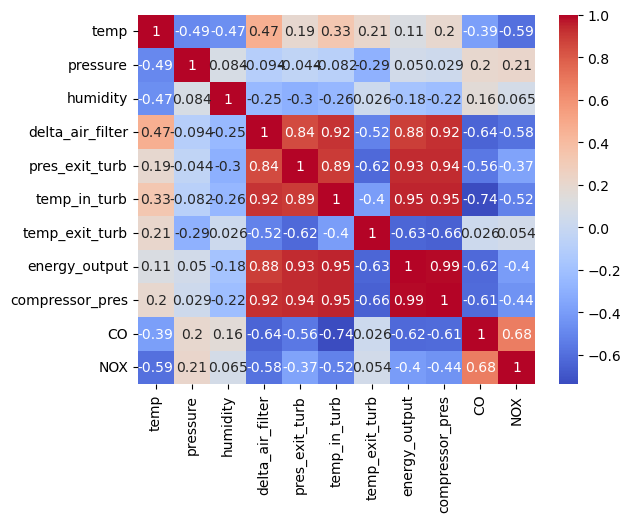

In [8]:
sns.heatmap(df.corr(), annot = True, cmap= 'coolwarm');

Признаки датасета можно разделить на три группы:
- физико-географические (температура, давление, влажность окружающей среды), которые зависят от локации расположения на планете и высоты на уровнем моря.
- физико-технические (перепад давления на воздушном фильтре, давление на выходе из газовой турбины, температура на входе в турбину, температура на выходе из турбины, энергоотдача турбины, давление нагнетания компрессора). Они зависят от изначального проекта электростанции. Проект, в свою очередь, отталкивается от нужд населения и промышленности, экономического развития региона.
- по выбросам в окружающую среду (выбросы угарного газа и оксидов азота).

Физико-географические признаки имеют нормальное стандартное распределение, так как подчиняются законам природы. Температура окружающей среды обратнокорреллирует с давлением и влажностью, как и должно быть.

Пять из шести физико-технических признаков имеют очень высокую прямую корреляцию друг с другом. Увеличение одной характеристики неизбежно ведет у евеличению других. Глядя на их распределения, на графиках можно увидеть три высоких "столба", что может говорить о существовании трех основных проектов/стандартов электростанций. Вероятно, зависят от года постройки и доступных на тот момент знаний и технологий. Также распределения ровно накладываются друг на друга, достаточно симметричны, что говорит о ровной работе большей части из них.

Выбросы вредных веществ имеют прямую корреляцию между собой и обратную корреляцию с физико-техническими признаками. Более современные станции с высокими техническими показателями выделяют меньше выбросов. Также выбросов больше у станций, находящихся в холодном климате. 

# Задание 2

Предположите по результатам разведочного анализа данных, какие группы электростанций существуют, чем они отличаются, каково их количество.

Обязательно должен быть класс нормально работающих станций. Может быть несколько классов, различающихся техническими характеристиками, но если они работают нормально, то выделять их необязательно. Считаю, что в данном кейсе, наиболее важно выделить станции, которые отличаются от других по большому количеству выбросов в окружающую среду. Это позволит провести детальный анализ технических характеристик и локаций месторасположений с целью минимизации выбросов при строительстве будущих станций. 5-7 кластеров будет достаточно.

# Задание 3

Постройте модель кластеризации DBSCAN. Подберите оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных в предыдущих заданиях.

In [9]:
# Так как алгоритм метрический, то важно привести признаки к единому масштабу.
scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()

,temp,pressure,humidity,delta_air_filter,pres_exit_turb,temp_in_turb,temp_exit_turb,energy_output,compressor_pres,CO,NOX
0,-1.886549,0.810866,1.206595,-1.751125,-1.344414,-1.532034,-0.313824,-1.095516,-1.142101,1.932653,4.793468
1,-1.977232,0.810866,1.394037,-1.975155,-1.686881,-1.693968,0.338426,-1.533762,-1.539805,1.493824,4.682972
2,-2.010579,1.115436,0.715465,-1.343871,-0.864246,-0.514884,0.602605,-0.501504,-0.739998,0.225305,2.538378
3,-2.003371,1.042919,0.612586,-1.281431,-0.619691,-0.191016,0.544304,-0.110234,-0.347573,0.030076,2.442346
4,-1.968993,1.028416,0.597077,-1.247506,-0.591749,-0.140412,0.553413,-0.025552,-0.316777,-0.334116,2.032436


In [10]:
# Алгоритм GridSearchCV не имеет встроенной метрики 'silhouette_score', поэтому создаем соответствующую функцию.
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)

cv = [(slice(None), slice(None))]    # кросс-валидация по фолдам в данном случае не нужна

In [11]:
%%time
# Инициализируем сетку параметров для перебора
param_grid = {
    'eps': np.arange(0.4, 1.51, 0.05), 
    'min_samples': list(range(4, 25))
}

# Инициализируем базовую модель
model = DBSCAN()

# Модель для перебора параметров базовой модели
grid_search_DBSCAN = GridSearchCV(estimator=model,
                                  param_grid=param_grid,
                                  scoring=cv_silhouette_scorer,
                                  cv=cv,
                                  verbose=1,
                                  n_jobs=-1)

# Выполняем перебор параметров
grid_search_DBSCAN.fit(df_scaled)

# Выводим лучшие параметры
print(grid_search_DBSCAN.best_params_)
print(grid_search_DBSCAN.best_score_)

Fitting 1 folds for each of 483 candidates, totalling 483 fits
{'eps': 1.4999999999999996, 'min_samples': 9}
0.4023360657036783
CPU times: total: 3.92 s
Wall time: 4min 1s


In [12]:
# Датафрейм из результатов сетчатого поиска, отсортированный по лучшей метрике 'silhouette_score'.
results = pd.DataFrame(grid_search_DBSCAN.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
results.sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
467,"{'eps': 1.4999999999999996, 'min_samples': 9}",0.402336,1
466,"{'eps': 1.4999999999999996, 'min_samples': 8}",0.402241,2
468,"{'eps': 1.4999999999999996, 'min_samples': 10}",0.398844,3
481,"{'eps': 1.4999999999999996, 'min_samples': 23}",0.398142,4
480,"{'eps': 1.4999999999999996, 'min_samples': 22}",0.397267,5
...,...,...,...
7,"{'eps': 0.4, 'min_samples': 11}",-0.460709,479
9,"{'eps': 0.4, 'min_samples': 13}",-0.482209,480
8,"{'eps': 0.4, 'min_samples': 12}",-0.482824,481
11,"{'eps': 0.4, 'min_samples': 15}",-0.488955,482


In [13]:
model = DBSCAN(eps=1.5, min_samples=9)
model.fit(df_scaled)

DBSCAN(eps=1.5, min_samples=9)

In [14]:
print('Количество кластеров: ', len(np.unique(model.labels_)))
print('Количество экземпляров класса "выбросы": ', np.sum(model.labels_==-1))

Количество кластеров:  2
Количество экземпляров класса "выбросы":  85


Стратегия максимизации метрики 'silhouette_score' в данном случае нам не подходит. В выше указанной модели был достигнут показатель метрики 0.4, но количество кластеров составило 2, один из которых составлял всего около 1% объектов от общего их числа. Это не дает желаемой информации о существовании различных кластеров электростанций и их особенностях.

Важно найти баланс между метрикой и количеством кластеров. Поэтому пройдем в цикле по двум гиперпараметрам. Для каждой итерации сохраним в список сами гиперпараметры, достигнутый silhouette_score, количество кластеров и количество объектов в кластере '-1'.

In [15]:
%%time
stats = []
for min_samples in range(4, 25):
    for eps in np.arange(0.4, 1.51, 0.05):
        model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        model.fit(df_scaled)
      
        sil_sc = silhouette_score(df_scaled, model.labels_)
        num_labels = len(np.unique(model.labels_))
        num_outliers = np.sum(model.labels_==-1)
    
        stats.append([min_samples, eps, sil_sc, num_labels, num_outliers])

CPU times: total: 29min 18s
Wall time: 8min 55s


In [16]:
# Преобразование списка в датафрейм.
score_df = pd.DataFrame(stats, columns=['min_samples', 'eps', 'silhouette_score', 'num_labels', 'num_outliers'])
print(score_df.shape)
score_df.head()

(483, 5)


,min_samples,eps,silhouette_score,num_labels,num_outliers
0,4,0.40,-0.355205,212,3224
1,4,0.45,-0.315501,197,2520
2,4,0.50,-0.319741,152,2026
3,4,0.55,-0.349040,116,1559
4,4,0.60,-0.405552,92,1223


In [17]:
# Строки с метрикой > 0.1 и количеством класторов > 4.
score_df[(score_df['silhouette_score'] > 0.1) & (score_df['num_labels'] > 4)]

,min_samples,eps,silhouette_score,num_labels,num_outliers
83,7,1.10,0.110866,5,219
106,8,1.10,0.262736,5,237
175,11,1.10,0.248658,5,297
198,12,1.10,0.247322,5,309
199,12,1.15,0.254558,5,268
223,13,1.20,0.258468,5,236
246,14,1.20,0.259032,5,251


In [18]:
# Строки с метрикой > 0 и количеством класторов > 5.
score_df[(score_df['silhouette_score'] > 0) & (score_df['num_labels'] > 5)]

,min_samples,eps,silhouette_score,num_labels,num_outliers
17,4,1.25,0.006816,6,96
18,4,1.30,0.006692,6,80
38,5,1.15,0.014472,7,147
39,5,1.20,0.016696,6,129
41,5,1.30,0.006622,6,87
61,6,1.15,0.015920,6,161
62,6,1.20,0.015955,6,147
63,6,1.25,0.016499,6,129
151,10,1.05,0.007176,7,332
174,11,1.05,0.008009,7,355


В качестве финальной модели принимаем решение взять ту, которая которая достаточно хорошо разделяет кластеры (метрика = 0.2545, количество кластеров равно 5, и количество объектов класса не самое маленькое.

# Задание 4

Интерпретируйте результаты кластеризации: объясните, чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных. 

In [19]:
# Обучение финальной модели.
model_best = DBSCAN(eps=1.15, min_samples=12)
model_best.fit(df_scaled)

DBSCAN(eps=1.15, min_samples=12)

In [20]:
# Добавляем к НЕстандартизованному датафрейму столбец с метками классов.
df['Label'] = model_best.labels_
df.head()

,temp,pressure,humidity,delta_air_filter,pres_exit_turb,temp_in_turb,temp_exit_turb,energy_output,compressor_pres,CO,NOX,Label
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250,-1
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020,-1
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147,0
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078,0
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515,0


In [21]:
# Подсчет количества значений кластеров.
df.Label.value_counts()

 0    7047
-1     268
 1      37
 3      17
 2      15
Name: Label, dtype: int64

In [22]:
# Доли кластеров.
df.Label.value_counts(normalize=True)

 0    0.954361
-1    0.036295
 1    0.005011
 3    0.002302
 2    0.002031
Name: Label, dtype: float64

In [23]:
# Группировка кластеров по среднему значению каждого признака.
features = ['temp', 'pressure', 'humidity', 'delta_air_filter', 'pres_exit_turb', 'temp_in_turb', 'temp_exit_turb',
            'energy_output', 'compressor_pres', 'CO', 'NOX' ]

df_stats = df.groupby('Label').agg({x: 'mean' for x in features}).T
df_stats

Label,-1,0,1,2,3
temp,10.514699,17.636043,-4.272205,0.988999,13.847941
pressure,1017.234627,1014.240725,1034.610811,1022.153333,1032.300000
humidity,68.117123,68.711424,62.128919,75.892467,58.289529
delta_air_filter,3.291733,3.611645,4.235222,2.653620,2.611018
pres_exit_turb,25.159877,26.151541,35.677108,18.878333,18.178529
temp_in_turb,1062.164925,1079.690379,1099.970270,1044.993333,1031.588235
temp_exit_turb,541.146269,546.994132,521.660811,547.463333,541.167647
energy_output,127.198881,134.162137,174.905946,110.490667,102.844706
compressor_pres,11.674279,12.106825,14.800730,10.479400,10.241706
CO,7.226293,2.946030,2.059771,9.356460,11.643024


In [24]:
# Добавляем колонку со средним значением каждого признака по всему датасету.
stats = np.array([df[feature].apply('mean') for feature in features]).flatten()

df_stats['Global'] = stats
df_stats

Label,-1,0,1,2,3,Global
temp,10.514699,17.636043,-4.272205,0.988999,13.847941,17.225259
pressure,1017.234627,1014.240725,1034.610811,1022.153333,1032.300000,1014.509110
humidity,68.117123,68.711424,62.128919,75.892467,58.289529,68.647464
delta_air_filter,3.291733,3.611645,4.235222,2.653620,2.611018,3.598909
pres_exit_turb,25.159877,26.151541,35.677108,18.878333,18.178529,26.130149
temp_in_turb,1062.164925,1079.690379,1099.970270,1044.993333,1031.588235,1078.974689
temp_exit_turb,541.146269,546.994132,521.660811,547.463333,541.167647,546.642484
energy_output,127.198881,134.162137,174.905946,110.490667,102.844706,133.993380
compressor_pres,11.674279,12.106825,14.800730,10.479400,10.241706,12.097025
CO,7.226293,2.946030,2.059771,9.356460,11.643024,3.129986


In [25]:
# Процентное отклонение признаков каждого кластера относительно среденего по датасету.
cluster_labels = [-1, 0, 1, 2, 3]

for label in cluster_labels:
    df_stats[label] = 100 * df_stats[label] / df_stats['Global'] - 100

df_stats

Label,-1,0,1,2,3,Global
temp,-38.957675,2.384777,-124.801980,-94.258440,-19.606777,17.225259
pressure,0.268654,-0.026455,1.981421,0.753490,1.753645,1014.509110
humidity,-0.772557,0.093172,-9.495682,10.553926,-15.088590,68.647464
delta_air_filter,-8.535249,0.353895,17.680707,-26.265989,-27.449746,3.598909
pres_exit_turb,-3.713227,0.081867,36.536185,-27.752675,-30.430823,26.130149
temp_in_turb,-1.557939,0.066331,1.945883,-3.149412,-4.391804,1078.974689
temp_exit_turb,-1.005450,0.064329,-4.570020,0.150162,-1.001539,546.642484
energy_output,-5.070773,0.125944,30.533274,-17.540205,-23.246428,133.993380
compressor_pres,-3.494625,0.081015,22.350165,-13.372088,-15.336985,12.097025
CO,130.873052,-5.877185,-34.192305,198.929816,271.983301,3.129986


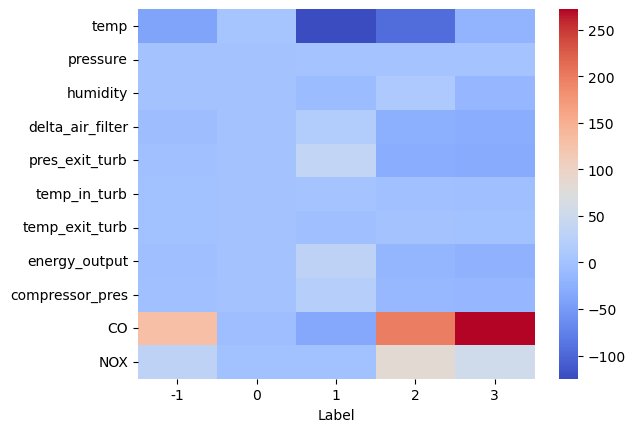

In [26]:
# Визуализация относительных отклонений.
sns.heatmap(df_stats[cluster_labels], cmap='coolwarm');

**Проанализировав абсолютные значения, относительные отклонения кластеров и визуализацию, можно сделать следующие выводы.**

**Кластер "0".** Значения практически не отличаются от средних по датасету. Содержит нормально работающие электростанции в нормальных условиях.

**Кластер "-1".** Выбросы угарного газа высокие, азот - выше среднего. Температура окружающей среды достаточно ниже среденей. 

**Кластер "1".** Самые экологичные: выбросы наименьшиие. Работают при отрицательных температурах. Физико-технические характеристики (в том числе, энергоотдача турбины) самые высокие. 

**Кластер "2".** Выбросы угарного газа очень высокие, азота - самые высокие. Работают при температуре около нуля. Физико-технические характеристики значительно ниже средних. 

**кластер "3".** Выбросы угарного газа самые высокие, азота - очень высокие. Работают при температурах ниже средней. Физико-технические характеристики значительно ниже средних.

Как видно из визуализации разделение хорошо прошло по размеру выбросов вредных веществ в окружающую среду, что является наиболее важным. После более детального анализа это позволит подкорректировать работу текущих станций и в будущем проектировать станции с правильными параметрами в подходящих локациях.